In [1]:
import sys
import time
import random
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt

from jyro.simulator import Canvas, Physics, Pioneer, Pioneer16Sonars, MyroIR

from IPython.display import display, clear_output

from maps.map import Map

## Map

Map dimensions: 25 x 25 meters
Obstacle ratio: 0.4096


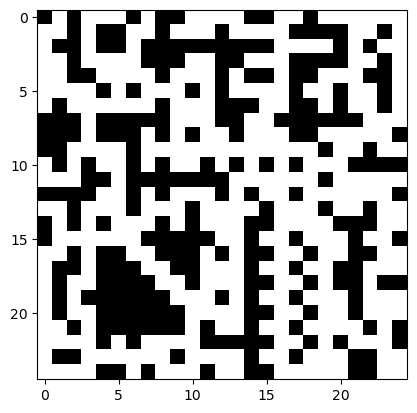

In [2]:
map = Map()
map_arr = map.load_map('maps/saved_maps/map_4.npy')
map.display()

print(f'Map dimensions: {map_arr.shape[0]} x {map_arr.shape[1]} meters')
print(f'Obstacle ratio: {map.get_obstacle_ratio()}')

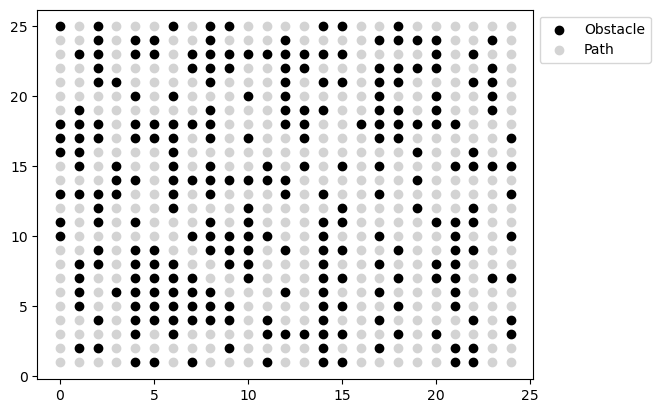

In [3]:
# Get Cartesian coordinates
cartesian_coords = map.image_to_cartesian()
obstacle_coords = cartesian_coords[1]
path_coords = cartesian_coords[0]


assert len(obstacle_coords)+len(path_coords) == np.prod(map_arr.shape)

# Plot to confirm
plt.scatter(obstacle_coords[:, 0], obstacle_coords[:, 1], color='black', label='Obstacle')
plt.scatter(path_coords[:, 0], path_coords[:, 1], color='lightgray', label='Path')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.show()

In [4]:
# Get upper left and lower right coordinates for each obstacle box
obstacle_boxes = []
for o_p in obstacle_coords:
    ul_x, ul_y = o_p
    lr_x = ul_x + 1
    lr_y = ul_y - 1
    obstacle_boxes.append((ul_x, ul_y, lr_x, lr_y))

## World

In [5]:
sim = Physics()

def make_world(sim):
    sim.addBox(0, 0, 25, 25, fill='white', wallcolor="black")
    
    for i in obstacle_boxes:
        ul_x, ul_y, lr_x, lr_y = i
        sim.addBox(ul_x, ul_y, lr_x, lr_y, fill='black')

make_world(sim)

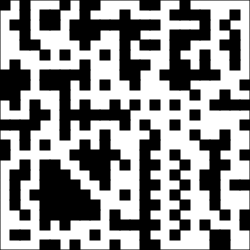

In [6]:
canvas = Canvas((250, 250))
sim.draw(canvas)

## Robot

In [7]:
## Robot class
class Robot(Pioneer):
    def __init__(self, name, x, y, theta, sensor='sonar', speed=0.5, noise=0.0):
        Pioneer.__init__(self, name, x, y, theta)
        self.noise=noise
        self.addDevice(Pioneer16Sonars(noise=self.noise))
        self.addDevice(MyroIR())

        self.sensor = sensor
        self.speed = speed
        
        self.turn_direction = -1.0
        self.turn_counter = 0

        

    def get_sensor_data(self):
        sonar_data = self['sonar'].getData()[1:7] # Only use front sensors
        ir_data = self['ir'].getData()
        return (sonar_data, ir_data)
    

def brain(robot):
    sonar_data, ir_data = robot.get_sensor_data()

    if robot.sensor == 'ir':
        obstacle_dist = min(ir_data)
    else:
        obstacle_dist = min(sonar_data)

    if robot.stall:
        pass
    if obstacle_dist < 0.5:
        direction = random.randint(0, 10)*0.1
        robot.move(0.0, direction*robot.turn_direction)
        robot.turn_counter += 1

        if robot.turn_counter > 500:
            robot.turn_direction *= -1.0
            robot.turn_counter = 0 

    else:
        robot.move(robot.speed, 0)


def check_box_collision(p, obstacle_boxes):
    if p[0] < 0.5 or p[0] > 24.5 or p[1] < 0.5 or p[1] > 24.5:
        return True
    for b in obstacle_boxes:
        if p[0] > b[0] - 0.5 and p[0] < b[2] + 0.5 and p[1] > b[3] - 0.5 and p[1] < b[1] + 0.5:
            return True
    return False


def get_random_start(path_coords, obstacle_boxes):
    collision = True
    while collision:
        x, y = random.choice(path_coords)
        x += random.random()*0.1
        y += random.random()*0.1
        collision = check_box_collision((x, y), obstacle_boxes)

    return x, y, random.random()*2*pi

Pose: 
  x = 6.036624897835634 
  y = 21.075444463161446 
  theta = 3.7998699546868884 = 1.2095361727895892 pi = 217.71651110212608 degrees


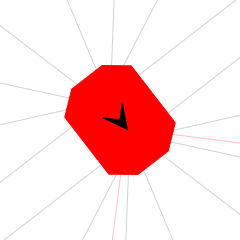

In [8]:
# Example robot
robot = Robot('Pioneer', *get_random_start(path_coords, obstacle_boxes))
robot.brain = brain

x, y, heading = robot.getPose()
print(f'Pose: \n  x = {x} \n  y = {y} \n  theta = {heading} = {heading / pi} pi = {heading * (180 / pi)} degrees')
robot


In [9]:
robot.get_sensor_data()

([8.0, 8.0, 8.0, 8.0, 8.0, 8.0], [0.5, 0.5])

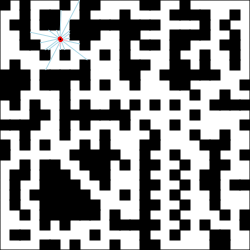

In [10]:
sim.addRobot(robot)
canvas = Canvas((250, 250))
sim.draw(canvas)

## Example Simulation

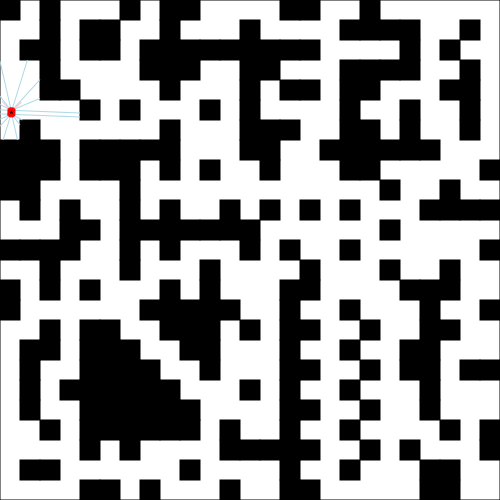

CPU times: user 10 s, sys: 39.5 ms, total: 10.1 s
Wall time: 10.1 s


In [11]:
%%time

sim = Physics()
make_world(sim)

robot = Robot('Pioneer', *get_random_start(path_coords, obstacle_boxes), sensor='sonar', speed=5.0, noise=0.1)
robot.brain = brain
sim.addRobot(robot)

canvas = Canvas((500, 500))

step_time = []
for i in range(100):
    sim.step(run_brain=True)
    for r in sim.robots:
        sim.draw(canvas)
        clear_output(wait=True)
        display(canvas)
        time.sleep(0.0)

In [12]:
robot.stall

0

## Dataset Generation

In [13]:
def generate_dataset(trials, steps, sensor, speeds, path):
    data = {
            'trial'         : [],
            'sensor'        : [], 
            'speed'         : [], 
            'x_init'        : [], 
            'y_init'        : [], 
            'theta_init'    : [], 
            'steps'         : [], 
            'stalled'       : [],
            'censored'      : []
    }

    for i in range(trials):
        sys.stdout.write(f'\r Running trial {i+1}/{trials}....')
        sys.stdout.flush()

        running = True
        while running:
            sim = Physics()
            make_world(sim)

            speed = random.choice(speeds)
            robot = Robot('Pioneer', *get_random_start(path_coords, obstacle_boxes), sensor=sensor, speed=speed, noise=0.1)
            x, y, theta = robot.getPose()
            sim.addRobot(robot)

            time_to_stall = np.nan

            for s in range(steps):
                brain(robot)
                sim.step()

                if robot.stall:
                    time_to_stall = s
                    break
            if time_to_stall != 0:
                running = False

        if np.isnan(time_to_stall):
            time_to_stall = steps
            censored = 1
        elif time_to_stall > 300:
            censored = 1
        else:
            censored = 0

        data['trial'].append(i)
        data['sensor'].append(sensor)
        data['speed'].append(speed)
        data['x_init'].append(x)
        data['y_init'].append(y)
        data['theta_init'].append(theta) 
        data['steps'].append(time_to_stall)
        data['stalled'].append(robot.stall)
        data['censored'].append(censored)

    sys.stdout.write('\rSimulation trials complete.')
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)

    return df


In [14]:
TRIALS = 15
STEPS = 1000
SPEEDS = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

ir_data = generate_dataset(TRIALS, STEPS, 'ir', SPEEDS, 'data/ir_simulations.csv')
ir_data

Simulation trials complete.

,trial,sensor,speed,x_init,y_init,theta_init,steps,stalled,censored
0,0,ir,8.0,23.033265,17.006460,5.277854,47,1,0
1,1,ir,5.0,16.075157,19.008258,3.468616,2,1,0
2,2,ir,7.0,13.024308,4.035999,1.675125,29,1,0
3,3,ir,6.0,12.090201,11.070986,2.919489,1,1,0
4,4,ir,6.0,11.066454,21.000817,4.737046,154,1,0
5,5,ir,5.0,24.073132,8.014609,1.815635,6,1,0
6,6,ir,7.0,12.089708,7.060024,5.985986,2,1,0
7,7,ir,8.0,6.031362,10.027173,0.412167,3,1,0
8,8,ir,8.0,13.025803,10.085996,1.144672,26,1,0
9,9,ir,5.0,19.072338,10.014212,3.264810,3,1,0


In [15]:
sonar_data = generate_dataset(TRIALS, STEPS, 'sonar', SPEEDS, 'data/sonar_simulations.csv')
sonar_data

Simulation trials complete.

,trial,sensor,speed,x_init,y_init,theta_init,steps,stalled,censored
0,0,sonar,4.0,20.052758,5.048366,5.696617,629,1,1
1,1,sonar,8.0,17.014048,11.022718,4.987295,45,1,0
2,2,sonar,5.0,23.030841,17.009916,4.226365,205,1,0
3,3,sonar,7.0,22.005670,19.093222,5.214211,52,1,0
4,4,sonar,8.0,1.011612,21.074119,3.525034,41,1,0
5,5,sonar,7.0,11.059006,18.061388,5.563004,71,1,0
6,6,sonar,4.0,13.033099,10.004153,0.924671,39,1,0
7,7,sonar,7.0,5.067676,15.026983,5.517815,59,1,0
8,8,sonar,8.0,17.035908,11.065528,0.789077,317,1,1
9,9,sonar,5.0,23.045075,13.081538,0.845066,142,1,0


## Test Simulations

In [ ]:
def generate_test_dataset(samples, steps, speeds, path):
    data = {
            'trial'         : [],
            'sensor'        : [], 
            'speed'         : [], 
            'x_init'        : [], 
            'y_init'        : [], 
            'theta_init'    : [], 
            'steps'         : [], 
            'stalled'       : [],
            'censored'      : []
    }

    for i in range(trials):
        sys.stdout.write(f'\r Running trial {i+1}/{trials}....')
        sys.stdout.flush()

        running = True
        while running:
            sim = Physics()
            make_world(sim)

            speed = random.choice(speeds)
            robot = Robot('Pioneer', *get_random_start(path_coords, obstacle_boxes), sensor=sensor, speed=speed, noise=0.1)
            x, y, theta = robot.getPose()
            sim.addRobot(robot)

            time_to_stall = np.nan

            for s in range(steps):
                brain(robot)
                sim.step()

                if robot.stall:
                    time_to_stall = s
                    break
            if time_to_stall != 0:
                running = False

        if np.isnan(time_to_stall):
            time_to_stall = steps
            censored = 1
        elif time_to_stall > 300:
            censored = 1
        else:
            censored = 0

        data['trial'].append(i)
        data['sensor'].append(sensor)
        data['speed'].append(speed)
        data['x_init'].append(x)
        data['y_init'].append(y)
        data['theta_init'].append(theta) 
        data['steps'].append(time_to_stall)
        data['stalled'].append(robot.stall)
        data['censored'].append(censored)

    sys.stdout.write('\rSimulation trials complete.')
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)

    return df